In [1]:
%%capture
!pip install git+https://github.com/qubvel/classification_models.git
!pip install roboflow

In [2]:
import os, glob, random, re, zipfile, shutil, gc
import numpy as np
import pandas as pd
from roboflow import Roboflow
from functools import partial
import matplotlib.pyplot as plt

import tensorflow as tf
import tf_keras as keras
import tf_keras.backend as K
from tf_keras.losses import Loss
from tf_keras.layers import Layer
from tf_keras.optimizers import Adam
from tf_keras.callbacks import Callback
from tf_keras.saving import register_keras_serializable

import kagglehub

from tensorflow.keras import layers, Model, Input
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.applications import EfficientNetB3


from classification_models.tfkeras import Classifiers  # Requires: pip install git+https://github.com/qubvel/classification_models.git

2025-07-16 07:06:48.264989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752649608.471354      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752649608.530004      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Set a seed
seed = 42

np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [5]:
# Paths y parámetros
DATA_DIR     = '/kaggle/working/ROAD-CONDITIONS-3'
BATCH_SIZE   = 16
IMG_SIZE     = (512,512)
EPOCHS       = 30
API_KEY      = 'xQycEewyyN8CpgPGyEZw'


In [6]:
rf = Roboflow(api_key=API_KEY)
project = rf.workspace("road-conditions-nm3ay").project("road-conditions-pvned")
version = project.version(3)
dataset = version.download("multiclass")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ROAD-CONDITIONS-3 in multiclass:: 100%|██████████| 6485/6485 [00:00<00:00, 6828.61it/s]


In [7]:
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")

Number of devices: 1


I0000 00:00:1752649658.648486      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [8]:
class DataLoaderCls:
    def __init__(self, data_dir, batch_size, image_size, partition):
        self.base = os.path.join(data_dir, partition)
        self.batch = batch_size
        self.size  = image_size

        # Leemos CSV
        df = pd.read_csv(os.path.join(self.base, '_classes.csv'))
        # La primera columna es 'filename', el resto son etiquetas one-hot
        self.label_cols = [c for c in df.columns if c != 'filename']
        self.NUM_LABELS = len(self.label_cols)

        # Guardamos DataFrame
        df['image_path'] = df['filename'].apply(lambda f: os.path.join(self.base,f))
        self.df = df

    def _parse(self, img_path, label):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, self.size)
        img = img / 255.0
        return img, label

    def get_dataset(self):
        # Extraemos paths y vectores de etiquetas
        paths  = self.df['image_path'].values
        labels = self.df[self.label_cols].values.astype(np.float32)

        # Construimos tf.data.Dataset
        ds = tf.data.Dataset.from_tensor_slices((paths, labels))
        ds = ds.map(self._parse, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.shuffle(1000).batch(self.batch).prefetch(tf.data.AUTOTUNE)
        return ds

In [9]:
train_loader = DataLoaderCls(DATA_DIR, BATCH_SIZE, IMG_SIZE, 'train')
val_loader   = DataLoaderCls(DATA_DIR, BATCH_SIZE, IMG_SIZE, 'valid')
test_loader  = DataLoaderCls(DATA_DIR, BATCH_SIZE, IMG_SIZE, 'test')

ds_train = train_loader.get_dataset()
ds_val   = val_loader.get_dataset()
ds_test  = test_loader.get_dataset()

NUM_LABELS = train_loader.NUM_LABELS

In [10]:
label_names = train_loader.label_cols

In [11]:
with strategy.scope():
    
    # Helpers
    DefaultConv2D = partial(layers.Conv2D,
                            kernel_size=3, activation='relu', padding="same")
    
    def kernel_initializer(seed): 
        return tf.keras.initializers.GlorotUniform(seed=seed)
        
    def residual_block(x, filters, kernel_initializer, block_name):
        shortcut = x
        x = DefaultConv2D(filters, kernel_initializer=kernel_initializer, name=f'Conv_{block_name}_1')(x)
        x = layers.BatchNormalization(name=f'Batch_{block_name}_1')(x)
        x = DefaultConv2D(filters, kernel_initializer=kernel_initializer, name=f'Conv_{block_name}_2')(x)
        x = layers.BatchNormalization(name=f'Batch_{block_name}_2')(x)
        x = layers.Add(name=f'ResAdd_{block_name}')([shortcut, x])
        return layers.Activation('relu', name=f'ResAct_{block_name}')(x)

    # Input
    inputs = Input(shape=(*IMG_SIZE,3), name='image_input')
    
    # Backbone
    backbone = EfficientNetB3(include_top=False, weights='imagenet', input_tensor=inputs)
    
    # Head
    x = backbone.output
    x = DefaultConv2D(256, kernel_initializer=kernel_initializer(1), name='Head_Conv')(x)
    x = residual_block(x, 256, kernel_initializer(2), 'Head')
    x = layers.GlobalAveragePooling2D(name='Head_GAP')(x)
    x = layers.Dropout(0.3, name='Head_Dropout')(x)
    outputs = layers.Dense(NUM_LABELS, activation='sigmoid', name='predictions')(x)

    model = Model(inputs, outputs, name='multi_label')

    # Congelar backbone (menos BNs)
    for layer in backbone.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = False
            
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=1e-4
    )

    model.compile(
        optimizer= optimizer,
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS
)

Epoch 1/30


E0000 00:00:1752649721.088522      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/multi_label_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1752649729.576804     170 cuda_dnn.cc:529] Loaded cuDNN version 90300


355/355 ━━━━━━━━━━━━━━━━━━━━ 325s 805ms/step - accuracy: 0.9267 - loss: 0.1859 - precision: 0.8543 - recall: 0.8620 - val_accuracy: 0.9338 - val_loss: 0.2003 - val_precision: 0.8723 - val_recall: 0.8610
Epoch 2/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 279s 780ms/step - accuracy: 0.9758 - loss: 0.0732 - precision: 0.9497 - recall: 0.9535 - val_accuracy: 0.9824 - val_loss: 0.0609 - val_precision: 0.9674 - val_recall: 0.9620
Epoch 3/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 279s 781ms/step - accuracy: 0.9848 - loss: 0.0463 - precision: 0.9706 - recall: 0.9685 - val_accuracy: 0.9829 - val_loss: 0.0564 - val_precision: 0.9648 - val_recall: 0.9666
Epoch 4/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 278s 780ms/step - accuracy: 0.9868 - loss: 0.0381 - precision: 0.9732 - recall: 0.9739 - val_accuracy: 0.9850 - val_loss: 0.0546 - val_precision: 0.9712 - val_recall: 0.9685
Epoch 5/30
355/355 ━━━━━━━━━━━━━━━━━━━━ 278s 780ms/step - accuracy: 0.9906 - loss: 0.0300 - precision: 0.9816 - recall: 0.9809 - val_accuracy: 0.9843 - val

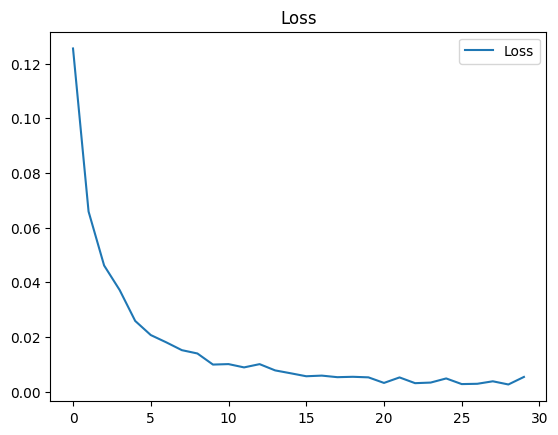

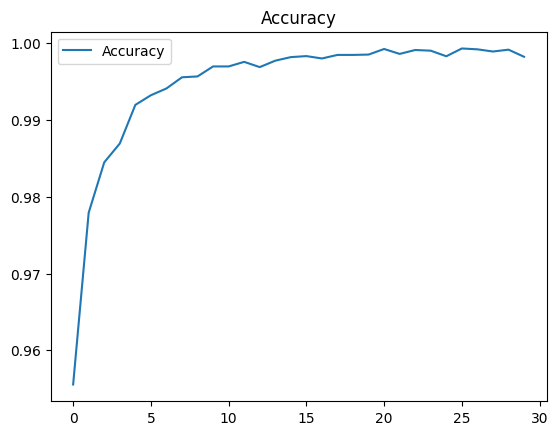

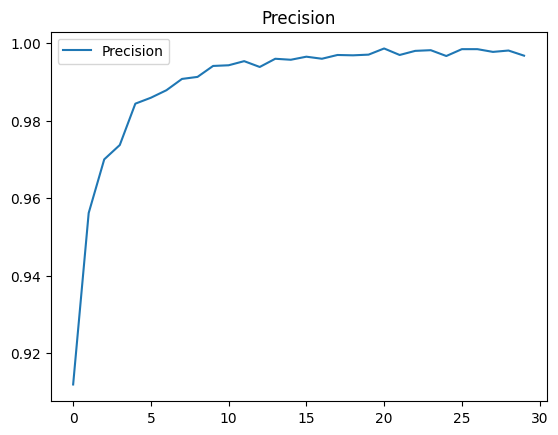

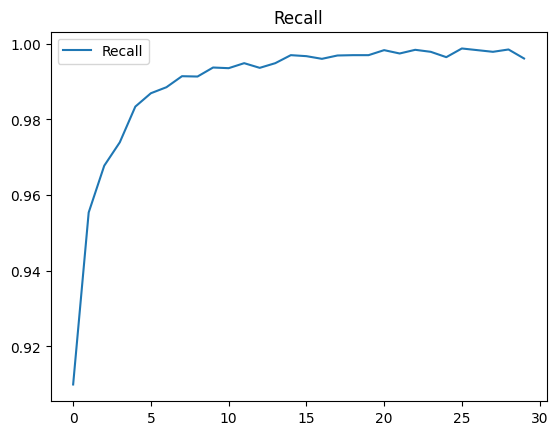

In [13]:
# -- Gráficas de métricas --
plt.figure(); 
plt.plot(history.history['loss'], label='Loss'); 
plt.title('Loss'); 
plt.legend(); 
plt.show()

plt.figure(); 
plt.plot(history.history['accuracy'], label='Accuracy'); 
plt.title('Accuracy'); 
plt.legend(); 
plt.show()

plt.figure(); 
plt.plot(history.history['precision'], label='Precision'); 
plt.title('Precision'); 
plt.legend(); 
plt.show()

plt.figure(); 
plt.plot(history.history['recall'], label='Recall'); 
plt.title('Recall'); 
plt.legend(); 
plt.show()

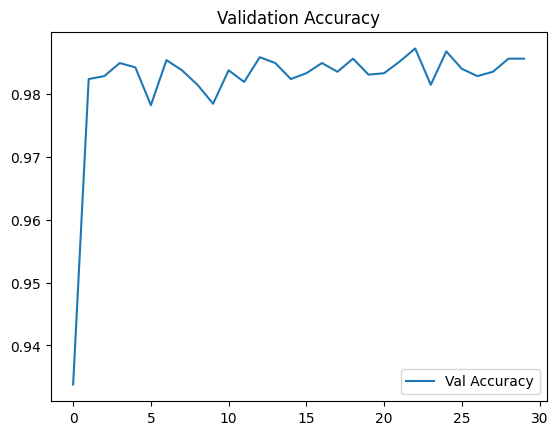

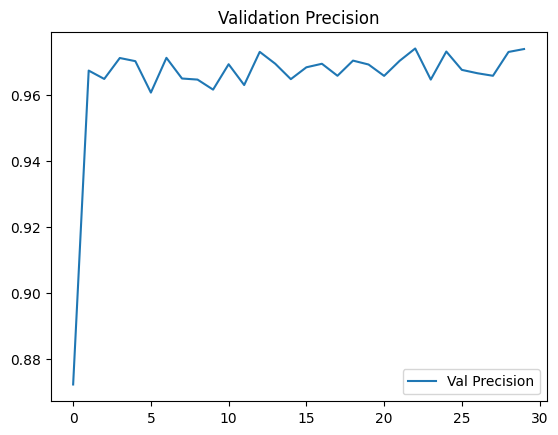

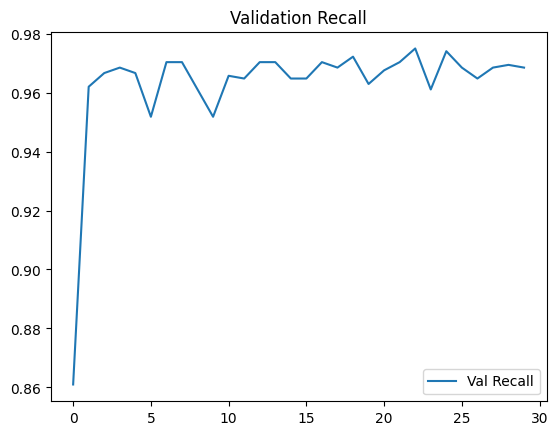

In [14]:
# -- Gráficas de métricas de validación --
plt.figure(); 
plt.plot(history.history['val_accuracy'], label='Val Accuracy'); 
plt.title('Validation Accuracy'); 
plt.legend(); 
plt.show()

plt.figure(); 
plt.plot(history.history['val_precision'], label='Val Precision'); 
plt.title('Validation Precision'); 
plt.legend(); 
plt.show()

plt.figure(); 
plt.plot(history.history['val_recall'], label='Val Recall'); 
plt.title('Validation Recall'); 
plt.legend(); 
plt.show()

In [ ]:
#model.save('road_conditions_2.h5')

In [90]:
model = kagglehub.model_download("fredycastao/road-conditions-model/keras/default/2")
output_folder = "./models"
os.makedirs(output_folder, exist_ok=True)

src_file = os.path.join(model, 'road_conditions_1.h5')
dst_file = os.path.join(output_folder, 'road_conditions_1.h5')
shutil.copy(src_file, dst_file)

'./models/road_conditions_1.h5'

# **PRUEBA DEL .H5**

Model: "multi_label"

Imagen elegida para prueba: /kaggle/working/ROAD-CONDITIONS-3/test/01360_jpg.rf.706e047c12dfd78fa04470daef4b8b78.jpg


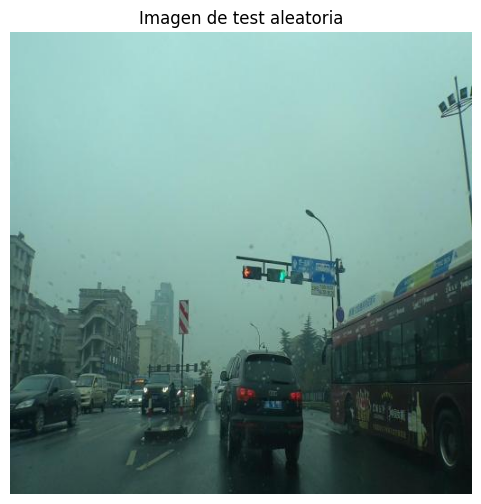

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step

Probabilidades por etiqueta:
Lighting_Dusk: 0.000
Surface_Dry: 0.008
Surface_Unknown: 0.000
Surface_Wet: 0.992
Weather_Clear: 0.012
Weather_Fog: 0.000
Weather_Rain: 0.989
Weather_Unknown: 0.000

Etiquetas seleccionadas:
Weather_Rain: 0.989
Surface_Wet: 0.992


In [55]:
from tensorflow.keras.models import load_model

# 1) Carga del modelo Keras guardado
model_h5 = load_model('road_conditions_2.h5')
model_h5.summary()

# 2) Selección aleatoria de una imagen del directorio de test
all_test_paths = glob.glob(os.path.join(DATA_DIR, 'test', '*.*'))
random_path = '/kaggle/working/ROAD-CONDITIONS-3/test/01360_jpg.rf.706e047c12dfd78fa04470daef4b8b78.jpg'
print("Imagen elegida para prueba:", random_path)

# 3) Mostrar la imagen con matplotlib
img_disp = Image.open(random_path)
plt.figure(figsize=(6,6))
plt.imshow(img_disp)
plt.axis('off')
plt.title("Imagen de test aleatoria")
plt.show()

# 4) Preprocesamiento (igual que en tu DataLoader)
def preprocess(path, size):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size) / 255.0
    return np.expand_dims(img.numpy(), axis=0)

img_array = preprocess(random_path, IMG_SIZE)

# 5) Inferencia con el modelo .h5
preds_h5 = model_h5.predict(img_array)[0]

# 6) Mostrar probabilidades por etiqueta
print("\nProbabilidades por etiqueta:")
for lab, p in zip(label_names, preds_h5):
    print(f"{lab}: {p:.3f}")

# 7) (Opcional) Post‑procesado por prefijos tal como tienes en TFLite
PREFIXES = ['Weather_', 'Surface_']
def postprocess(preds, labels, prefixes):
    paired = list(zip(labels, preds))
    results = []
    for prefix in prefixes:
        group = [(lab, p) for lab, p in paired if lab.startswith(prefix)]
        best = max(group, key=lambda x: x[1])
        results.append(best)
    return results

top_preds = postprocess(preds_h5, label_names, PREFIXES)
print("\nEtiquetas seleccionadas:")
for lab, p in top_preds:
    print(f"{lab}: {p:.3f}")

# **CONVERSIÓN A TFLITE**

In [57]:
# -- Función de carga TFLite  --
def load_tflite_model(tflite_path):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    print("Input details:", input_details)
    return interpreter, input_details, output_details

def preprocess_image(path, size):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size) / 255.0
    return np.expand_dims(img.numpy(), axis=0)

def infer_tflite(interpreter, input_details, output_details, img_array):
    interpreter.set_tensor(input_details[0]['index'], img_array.astype(np.float32))
    interpreter.invoke()
    return interpreter.get_tensor(output_details[0]['index'])[0]


In [64]:
# Convierte SIN optimizaciones
converter = tf.lite.TFLiteConverter.from_keras_model(model_h5)
# NO converter.optimizations = [...]
tflite_clean = converter.convert()
open('model_clean.tflite','wb').write(tflite_clean)

# Carga ese nuevo TFLite
interp_clean, in_det_clean, out_det_clean = load_tflite_model('model_clean.tflite')

Saved artifact at '/tmp/tmphdqobrs4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='image_input')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  133696241583888: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133696241590032: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133696134776400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133696133889104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133696133889680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133696134775248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133696134789072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133696133887376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133696133887760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133696133883728: TensorSpec(shape=(), dtype=tf.resource, name=None)

W0000 00:00:1752660059.769345      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1752660059.769389      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


Input details: [{'name': 'serving_default_image_input:0', 'index': 0, 'shape': array([  1, 512, 512,   3], dtype=int32), 'shape_signature': array([ -1, 512, 512,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [67]:
# Inferencia .h5
preds_h5 = model_h5.predict(img_array)[0]

# Inferencia TFLite “clean”
interp_clean.set_tensor(in_det_clean[0]['index'], img_array.astype(np.float32))
interp_clean.invoke()
preds_tfl = interp_clean.get_tensor(out_det_clean[0]['index'])[0]

print("H5:", np.round(preds_h5, 4))
print("TFL clean:", np.round(preds_tfl, 4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
H5: [0.     0.0076 0.     0.9924 0.012  0.     0.9893 0.    ]
TFL clean: [0.     0.0076 0.     0.9924 0.012  0.     0.9893 0.    ]


In [68]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_h5)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
# fuerza peso float16, pero deja la I/O en float32
converter.target_spec.supported_types = [tf.float16]
tflite_f16 = converter.convert()
open('model_f16.tflite','wb').write(tflite_f16)

Saved artifact at '/tmp/tmp7oufuf3m'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='image_input')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  133696241583888: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133696241590032: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133696134776400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133696133889104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133696133889680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133696134775248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133696134789072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133696133887376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133696133887760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133696133883728: TensorSpec(shape=(), dtype=tf.resource, name=None)

W0000 00:00:1752660356.404990      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1752660356.405023      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


30905224

In [69]:
interp_f16, in_det_f16, out_det_f16 = load_tflite_model('model_f16.tflite')

Input details: [{'name': 'serving_default_image_input:0', 'index': 0, 'shape': array([  1, 512, 512,   3], dtype=int32), 'shape_signature': array([ -1, 512, 512,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [74]:
# Inferencia .h5
preds_h5 = model_h5.predict(img_array)[0]

# Inferencia TFLite “clean”
interp_f16.set_tensor(in_det_f16[0]['index'], img_array.astype(np.float32))
interp_f16.invoke()
preds_tfl = interp_f16.get_tensor(out_det_f16[0]['index'])[0]

print("H5:", np.round(preds_h5, 4))
print("TFL clean:", np.round(preds_tfl, 4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
H5: [0.     0.0076 0.     0.9924 0.012  0.     0.9893 0.    ]
TFL clean: [0.     0.2501 0.     0.6992 0.4025 0.     0.8866 0.    ]


# En caso de que el modelo toca exportarlo

In [16]:
model_path = kagglehub.model_download("fredycastao/road-conditions-model/tflite/default/2")
output_folder = "./models"
os.makedirs(output_folder, exist_ok=True)

src_file = os.path.join(model_path, 'road_conditions_2.tflite')
dst_file = os.path.join(output_folder, 'road_conditions_2.tflite')
shutil.copy(src_file, dst_file)

'./models/road_conditions_2.tflite'

# **Prueba del modelo tflite**

In [76]:
tflite_path_clean = '/kaggle/working/model_clean.tflite'
interp, in_det, out_det = load_tflite_model(tflite_path_clean)

tflite_path_f16 = '/kaggle/working/model_f16.tflite'
interp_1, in_det_1, out_det_1 = load_tflite_model(tflite_path_f16)

Input details: [{'name': 'serving_default_image_input:0', 'index': 0, 'shape': array([  1, 512, 512,   3], dtype=int32), 'shape_signature': array([ -1, 512, 512,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Input details: [{'name': 'serving_default_image_input:0', 'index': 0, 'shape': array([  1, 512, 512,   3], dtype=int32), 'shape_signature': array([ -1, 512, 512,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [85]:
all_test_paths = glob.glob(os.path.join(DATA_DIR, 'test', '*.*'))
random_path = random.choice(all_test_paths)
print("Imagen elegida:", random_path)

Imagen elegida: /kaggle/working/ROAD-CONDITIONS-3/test/02812_jpg.rf.adacff1b29e08ae63a540787a365112e.jpg


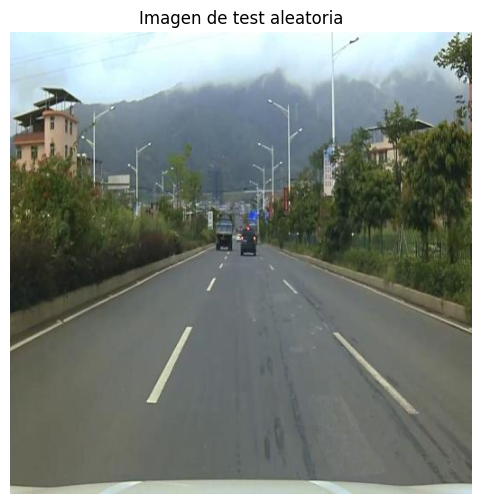

Lighting_Dusk: 0.000
Surface_Dry: 1.000
Surface_Unknown: 0.000
Surface_Wet: 0.000
Weather_Clear: 1.000
Weather_Fog: 0.000
Weather_Rain: 0.000
Weather_Unknown: 0.000

Etiquetas seleccionadas:
Weather_Clear: 1.000
Surface_Dry: 1.000


In [86]:
import matplotlib.pyplot as plt
from PIL import Image

img_disp = Image.open(random_path)
plt.figure(figsize=(6,6))
plt.imshow(img_disp); plt.axis('off'); plt.title("Imagen de test aleatoria")
plt.show()

# 5) Ejecutar inferencia
img = preprocess_image(random_path, IMG_SIZE)
preds = infer_tflite(interp, in_det, out_det, img)

# 6) Mostrar probabilidades por etiqueta
for lab, p in zip(label_names, preds):
    print(f"{lab}: {p:.3f}")

# 7) Postprocesado por prefijos
PREFIXES = ['Weather_', 'Surface_']
def postprocess_predictions(preds, labels, prefixes):
    paired = list(zip(labels, preds))
    results = []
    for prefix in prefixes:
        group = [(lab, p) for lab, p in paired if lab.startswith(prefix)]
        best = max(group, key=lambda x: x[1])
        results.append(best)
    return results

top4 = postprocess_predictions(preds, label_names, PREFIXES)
print("\nEtiquetas seleccionadas:")
for lab, p in top4:
    print(f"{lab}: {p:.3f}")


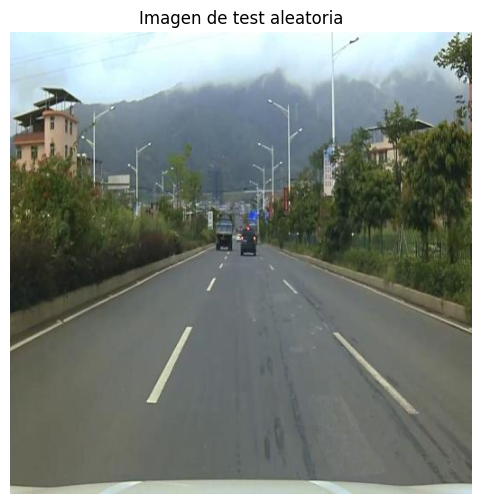

Lighting_Dusk: 0.000
Surface_Dry: 1.000
Surface_Unknown: 0.000
Surface_Wet: 0.000
Weather_Clear: 1.000
Weather_Fog: 0.000
Weather_Rain: 0.000
Weather_Unknown: 0.000

Etiquetas seleccionadas:
Weather_Clear: 1.000
Surface_Dry: 1.000


In [87]:
img_disp = Image.open(random_path)
plt.figure(figsize=(6,6))
plt.imshow(img_disp); plt.axis('off'); plt.title("Imagen de test aleatoria")
plt.show()

# 5) Ejecutar inferencia
img = preprocess_image(random_path, IMG_SIZE)
preds = infer_tflite(interp_1, in_det_1, out_det_1, img)

# 6) Mostrar probabilidades por etiqueta
for lab, p in zip(label_names, preds):
    print(f"{lab}: {p:.3f}")

# 7) Postprocesado por prefijos
PREFIXES = ['Weather_', 'Surface_']
def postprocess_predictions(preds, labels, prefixes):
    paired = list(zip(labels, preds))
    results = []
    for prefix in prefixes:
        group = [(lab, p) for lab, p in paired if lab.startswith(prefix)]
        best = max(group, key=lambda x: x[1])
        results.append(best)
    return results

top4 = postprocess_predictions(preds, label_names, PREFIXES)
print("\nEtiquetas seleccionadas:")
for lab, p in top4:
    print(f"{lab}: {p:.3f}")